In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

from sklearn.decomposition import PCA
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq

import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer

from shared_decoding.utils.ibl_data_utils import seed_everything
from shared_decoding.utils.ibl_data_loaders import SingleSessionDataModule, to_tensor
from shared_decoding.models.neural_models import eval_model

seed_everything(0)

/home/yizi/anaconda3/envs/ibl_foundation_model/lib/python3.11/site-packages/neurodsp/__init__.py:5: FutureWarning: neurodsp has been renamed to ibldsp and the old name will be deprecated on 01-Sep-2024.
  warn(


In [3]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

eids = [fname.split('.')[0] for fname in os.listdir(data_dir) if fname.endswith('npz')]
print(eids)

['0a018f12-ee06-4b11-97aa-bbbff5448e9f', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '111c1762-7908-47e0-9f40-2f2ee55b6505', '09b2c4d1-058d-4c84-9fd4-97530f85baf6']


In [4]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})

In [6]:
import numba

def behavior_decomp(eid, target, model, model_class, data_dir, decomp_type='PCA'):

    DEVICE = torch.device('cpu')

    config = {
        'data_dir': data_dir,
        'temporal_rank': 5,
        'weight_decay': 1e-1,
        'learning_rate': 1e-2,
        'batch_size': 8,
        'eid': eid,
        'imposter_id': None,
        'target': target,
        'lstm_hidden_size': 32,
        'lstm_n_layers': 3,
        'mlp_hidden_size': (256, 128, 64),
        'drop_out': 0.,
        'lr_factor': 0.1,
        'lr_patience': 5,
        'device': DEVICE,
        'n_workers': os.cpu_count(),
        'comp_idxs': list(np.arange(50))
    }

    dm = SingleSessionDataModule(config)
    dm.setup()

    train_y = []
    for (x, y) in dm.train:
        train_y.append(y.cpu())
    train_y = torch.stack(train_y)
    
    val_y = []
    for (x, y) in dm.val:
        val_y.append(y.cpu())
    val_y = np.stack(val_y)
    
    test_y = []
    for (x, y) in dm.test:
        test_y.append(y.cpu())
    test_y = np.stack(test_y)

    all_y = np.vstack([train_y, val_y, test_y])

    r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type=model_class, plot=False)

    # PCA 
    if decomp_type == 'PCA':
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y.reshape((-1, config['n_t_steps'])))
        pca_basis = pca.components_
        pca_var_explained = pca.explained_variance_ratio_
    
        signal_decomp = (pca_basis @ test_y.transpose()).var(-1)
        recon_decomp = (pca_basis @ test_pred.transpose()).var(-1)
        error_decomp = (pca_basis @ (test_pred - test_y).transpose()).var(-1)
        return signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y

    # Fourier
    if decomp_type == 'Fourier':

        @numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
        def norm(x):
            return x.real**2 + x.imag**2
        
        def fourier_decomp(data, config, delta_t=20):
            N = config['n_t_steps']
            delta_t = 20 # ms
            sampling_rate = 2*config['n_t_steps']*delta_t
            freq = np.abs(fftfreq(N, d=1/sampling_rate))
            fft_coef = fft(data)
            decomp = []
            for f in np.unique(freq):
                sp = 0
                for idx in np.argwhere(freq == f):
                    sp += norm(fft_coef[:,idx]).mean()
                decomp.append(np.mean(sp))
            decomp = np.array(decomp)
            return decomp

        signal_decomp = fourier_decomp(test_y, config, delta_t=20)
        recon_decomp = fourier_decomp(test_pred, config, delta_t=20)
        error_decomp = fourier_decomp(test_pred - test_y, config, delta_t=20)
        return signal_decomp, recon_decomp, error_decomp, _, r2, test_pred, test_y


In [7]:
def recon_from_pcs(y, pca, comp_idx=[0]):
    if len(comp_idx) == 1:
        recon_y = np.dot(pca.transform(y)[:,comp_idx[0],None], pca.components_[None,comp_idx[0],:])
    else:
        recon_y = np.dot(pca.transform(y)[:,comp_idx], pca.components_[comp_idx,:])
    recon_y += pca.mean_
    return recon_y    

def r2_decomp(eid, target, model, model_class, data_dir, n_comp=30):

    DEVICE = torch.device('cpu')

    config = {
        'data_dir': data_dir,
        'temporal_rank': 5,
        'weight_decay': 1e-1,
        'learning_rate': 1e-2,
        'batch_size': 8,
        'eid': eid,
        'imposter_id': None,
        'target': target,
        'lstm_hidden_size': 32,
        'lstm_n_layers': 3,
        'mlp_hidden_size': (256, 128, 64),
        'drop_out': 0.,
        'lr_factor': 0.1,
        'lr_patience': 5,
        'device': DEVICE,
        'n_workers': os.cpu_count(),
        'comp_idxs': list(np.arange(50))
    }

    dm = SingleSessionDataModule(config)
    dm.setup()

    def decode_per_pc_component(comp_idx):

        train_x, train_y = [], []
        for (x, y) in dm.train:
            train_x.append(x.cpu())
            train_y.append(y.cpu())
        train_x = np.stack(train_x)
        train_y = np.stack(train_y)
        
        val_x, val_y = [], []
        for (x, y) in dm.val:
            val_x.append(x.cpu())
            val_y.append(y.cpu())
        val_x = np.stack(val_x)
        val_y = np.stack(val_y)
        
        test_x, test_y = [], []
        for (x, y) in dm.test:
            test_x.append(x.cpu())
            test_y.append(y.cpu())
        test_x = np.stack(test_x)
        test_y = np.stack(test_y)
        
        all_y = np.vstack([train_y, val_y, test_y])
    
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y)

        _train_y = recon_from_pcs(train_y, pca, comp_idx=comp_idx)
        _test_y = recon_from_pcs(test_y, pca, comp_idx=comp_idx)

        _train = [(to_tensor(train_x[i], DEVICE), to_tensor(_train_y[i], DEVICE)) for i in range(len(train_x))]
        _test = [(to_tensor(test_x[i], DEVICE), to_tensor(_test_y[i], DEVICE)) for i in range(len(test_x))]

        r2, _, _ = eval_model(_train, _test, model, model_type='ridge', plot=False)

        return r2

    r2, _, _ = eval_model(dm.train, dm.test, model, model_type='ridge', plot=False)
    print(f'Original Data R2: {r2}')
    r2s = [r2]
    for comp_idx in range(n_comp):
        r2 = decode_per_pc_component([comp_idx])
        print(f'PC {comp_idx+1} R2: {r2}')
        r2s.append(r2)
    return r2s

##### PCA Behavior Decomposition

In [150]:
eid = eids[0]
target = 'pupil_diameter'

In [151]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained, _, _, _ = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='PCA'
)

spike data shape: (474, 50, 530)
behavior data shape: (474, 50)
(474, 50)
Use reconstructed behaviors from PCs:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


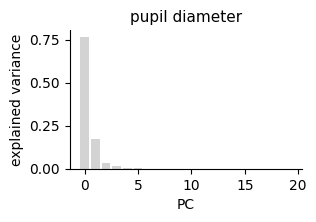

In [152]:
fig, ax = plt.subplots(figsize=(3,1.8))
ax.bar(
    np.arange(len(pca_var_explained[:20])), 
    pca_var_explained[:20], color='lightgrey')
ax.set_title(f'{" ".join(target.split("_"))}', fontsize=11)
ax.set_xlabel('PC')
ax.set_ylabel('explained variance')
ax.spines[['right', 'top']].set_visible(False);

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.legend(frameon=False);

##### Fourier Behavior Decomposition

In [ ]:
signal_decomp, recon_decomp, error_decomp, pca_var_explained = behavior_decomp(
    eids[0], target=target, 
    model=model, model_class='ridge', data_dir=data_dir, decomp_type='Fourier'
)

In [ ]:
plt.figure(figsize=(3,2))
plt.plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='behavior')
plt.plot(recon_decomp, c='orange', linewidth=1.5, alpha=1., label='pred')
plt.plot(error_decomp, c='k', linewidth=1, alpha=1., linestyle='--', label='error (pred - behavior)')
plt.title(f'{target} ({eid[:8]})')
plt.xlabel('frequency')
plt.legend(frameon=False);

spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)


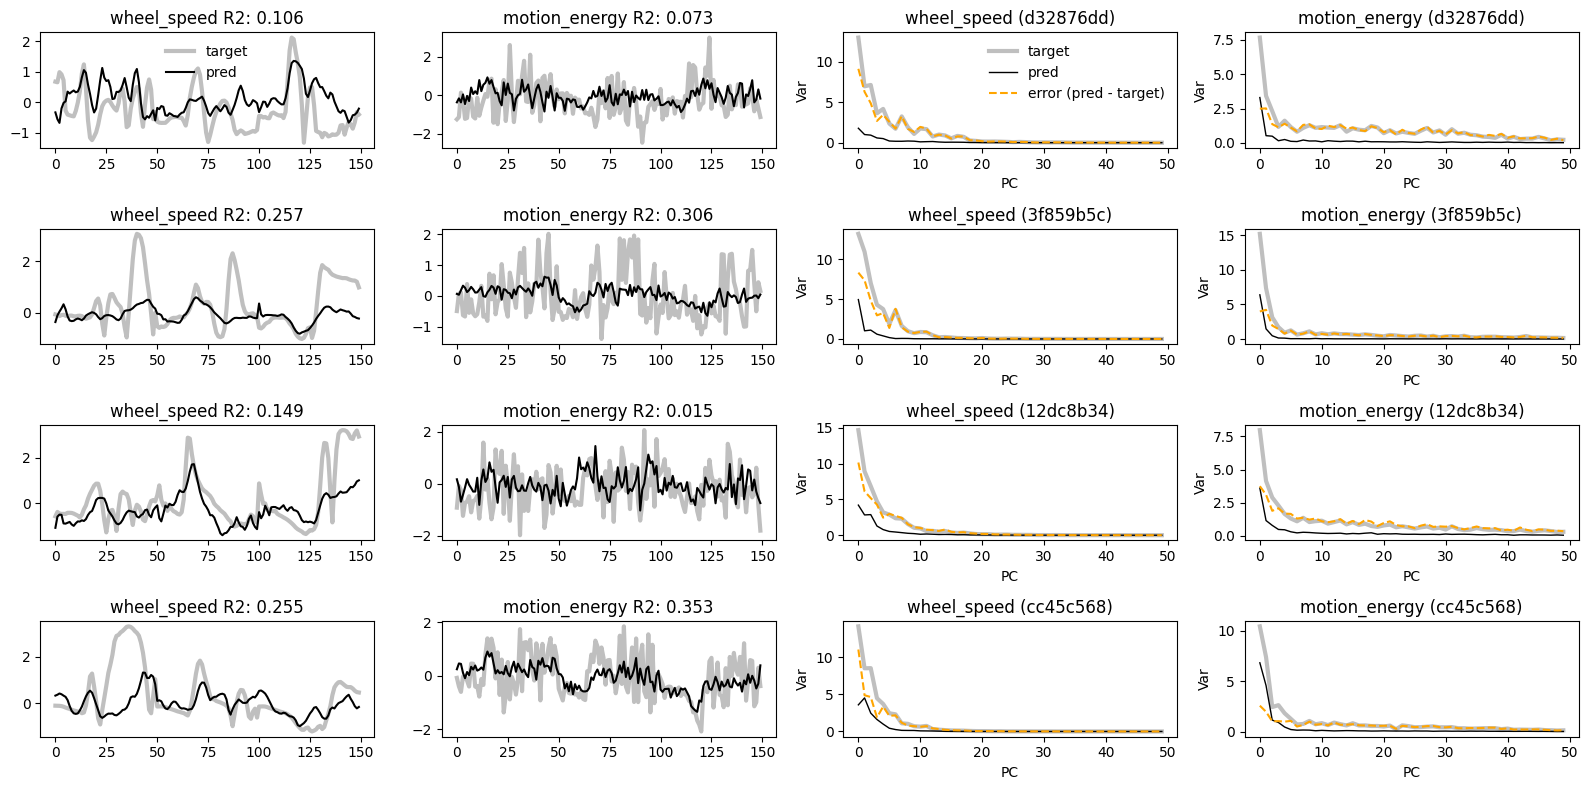

In [5]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('PC')
        axes[i,j+2].set_ylabel('Var')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
plt.savefig('../results/plots/pca_behavior_decomp.png', dpi=200)

spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (414, 50, 408)
behavior data shape: (414, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (490, 50, 1839)
behavior data shape: (490, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (907, 50, 245)
behavior data shape: (907, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)


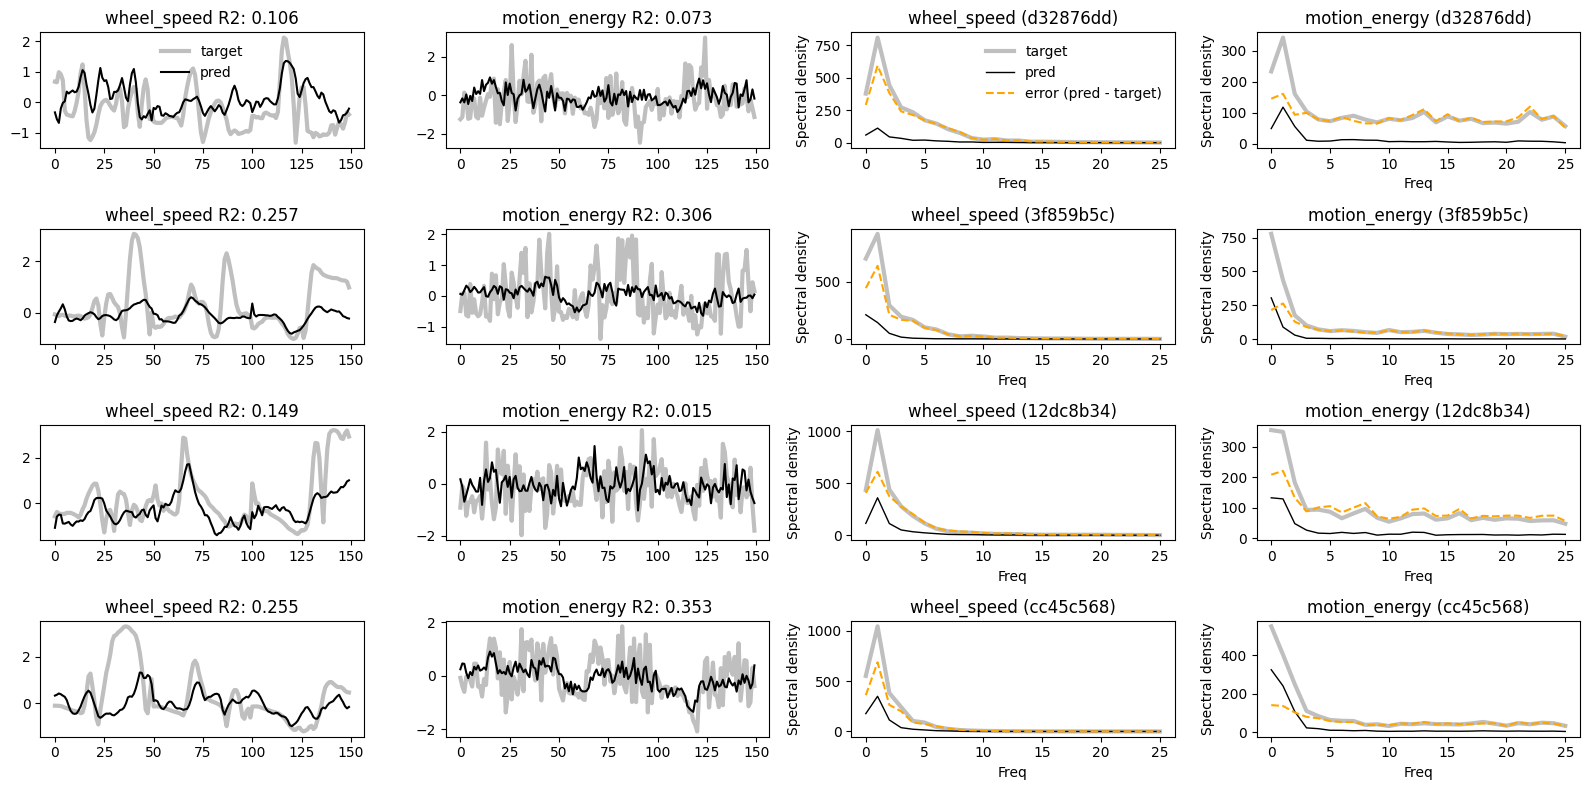

In [6]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy']
fig, axes = plt.subplots(n_eids, len(targets)+2, figsize=(4*len(targets)*2, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='Fourier'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+2].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+2].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+2].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+2].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2].set_xlabel('Freq')
        axes[i,j+2].set_ylabel('Spectral density')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,2].legend(frameon=False)
            
plt.tight_layout()
# plt.savefig('../results/plots/fourier_behavior_decomp.png', dpi=200)

In [ ]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy', 'pupil_diameter']

fourier_decomp = {}
for target in targets:  
    fourier_decomp[target] = {}
    gt, pred, error = [], [], []
    for eid in eids:      
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='Fourier'
        )
        gt.append(signal_decomp)
        pred.append(recon_decomp)
        error.append(error_decomp)
    fourier_decomp[target]['gt'] = np.mean(gt, 0)
    fourier_decomp[target]['pred'] = np.mean(pred, 0)
    fourier_decomp[target]['error'] = np.mean(error, 0)

In [ ]:
pca_decomp = {}
for target in targets:  
    pca_decomp[target] = {}
    gt, pred, error, pca_var = [], [], [], []
    for eid in eids:      
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        gt.append(signal_decomp)
        pred.append(recon_decomp)
        error.append(error_decomp)
        pca_var.append(pca_var_explained)
    pca_decomp[target]['gt'] = np.mean(gt, 0)
    pca_decomp[target]['pred'] = np.mean(pred, 0)
    pca_decomp[target]['error'] = np.mean(error, 0)
    pca_decomp[target]['pca_var'] = np.mean(pca_var, 0)
    pca_decomp[target]['test_y'] = test_y
    pca_decomp[target]['test_pred'] = test_pred

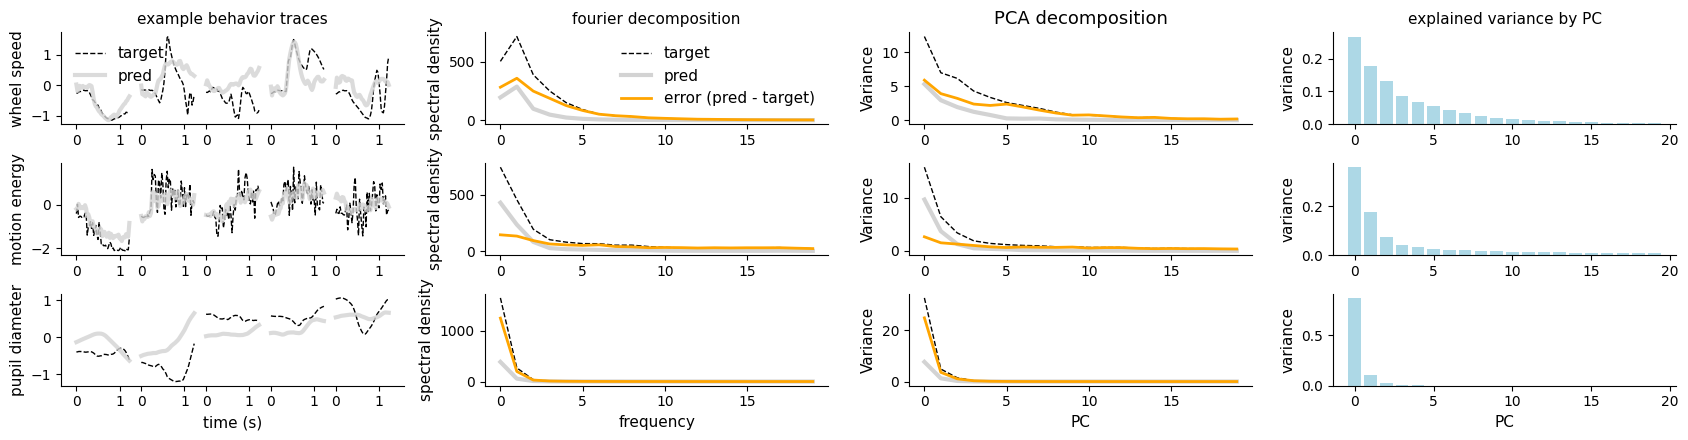

In [129]:
fig, axes = plt.subplots(3, 4, figsize=(17, 4.5))

for i, target in enumerate(targets): 
    y_viz = np.concatenate([np.hstack([pca_decomp[target]['test_y'][idx], np.array(10*[np.nan])]) for idx in range(5)])
    pred_viz = np.concatenate([np.hstack([pca_decomp[target]['test_pred'][idx], np.array(10*[np.nan])]) for idx in range(5)])
    axes[i,0].plot(y_viz, c='k', linestyle='--', linewidth=1., alpha=1., label='target')
    axes[i,0].plot(pred_viz, c='lightgray', linewidth=3, alpha=.8, label='pred')
    axes[i,0].set_xticks([0, 40, 60, 100, 120, 160, 180, 220, 240, 280], np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))
    axes[-1,0].set_xlabel('time (s)', fontsize=11)
    axes[i,0].set_ylabel(f'{" ".join(target.split("_"))}', fontsize=11)
    axes[0,0].set_title('example behavior traces', fontsize=11)
    axes[i,0].spines[['right', 'top']].set_visible(False)
    axes[0,0].legend(frameon=False, fontsize=11)

    axes[i,1].plot(fourier_decomp[target]['gt'][:20], c='k', linestyle='--', linewidth=1., alpha=1., label='target')
    axes[i,1].plot(fourier_decomp[target]['pred'][:20], c='lightgray', linewidth=3., alpha=1., label='pred')
    axes[i,1].plot(fourier_decomp[target]['error'][:20], c='orange', linewidth=2, alpha=1., linestyle='-', label='error (pred - target)')
    axes[0,1].legend(frameon=False, fontsize=11)
    axes[0,1].set_title('fourier decomposition', fontsize=11)
    axes[i,1].spines[['right', 'top']].set_visible(False)
    axes[-1,1].set_xlabel('frequency', fontsize=11)
    axes[i,1].set_ylabel('spectral density', fontsize=11)

    axes[i,2].plot(pca_decomp[target]['gt'][:20], c='k', linestyle='--', linewidth=1., alpha=1.,  label='target')
    axes[i,2].plot(pca_decomp[target]['pred'][:20], c='lightgray', linewidth=3., alpha=1., label='pred')
    axes[i,2].plot(pca_decomp[target]['error'][:20], c='orange', linewidth=2, alpha=1., linestyle='-', label='error (pred - target)')
    # axes[0,2].legend(frameon=False)
    axes[0,2].set_title('PCA decomposition', fontsize=13)
    axes[i,2].spines[['right', 'top']].set_visible(False)
    axes[-1,2].set_xlabel('PC', fontsize=11)
    axes[i,2].set_ylabel('Variance', fontsize=11)
    
    axes[i,-1].bar(
        np.arange(20), 
        pca_decomp[target]['pca_var'][:20], color='lightblue'
    )
    axes[0,-1].set_title('explained variance by PC', fontsize=11)
    axes[-1,-1].set_xlabel('PC', fontsize=11)
    axes[i,-1].set_ylabel('variance', fontsize=11)
    axes[i,-1].spines[['right', 'top']].set_visible(False);
        
plt.tight_layout()
plt.savefig(f'../results/plots/behave_decomp.png', dpi=500)

##### Decode Each Component

In [169]:
eid = eids[-1]
target = 'motion_energy'

In [170]:
DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eid,
    'imposter_id': None,
    'target': target,
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

dm = SingleSessionDataModule(config)
dm.setup()

spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)


In [171]:
train_x, train_y = [], []
for (x, y) in dm.train:
    train_x.append(x.cpu())
    train_y.append(y.cpu())
train_x = np.stack(train_x)
train_y = np.stack(train_y)

val_x, val_y = [], []
for (x, y) in dm.val:
    val_x.append(x.cpu())
    val_y.append(y.cpu())
val_x = np.stack(val_x)
val_y = np.stack(val_y)

test_x, test_y = [], []
for (x, y) in dm.test:
    test_x.append(x.cpu())
    test_y.append(y.cpu())
test_x = np.stack(test_x)
test_y = np.stack(test_y)

all_y = np.vstack([train_y, val_y, test_y])

In [172]:
pca = PCA(n_components=config['n_t_steps'])
pca.fit(all_y)
pca_basis = pca.components_
pca_var_explained = pca.explained_variance_ratio_

In [173]:
_train_y = recon_from_pcs(train_y, pca, comp_idx=[0,1])
_test_y = recon_from_pcs(test_y, pca, comp_idx=[0,1])

In [174]:
_train = [(to_tensor(train_x[i], DEVICE), to_tensor(_train_y[i], DEVICE)) for i in range(len(train_x))]
_test = [(to_tensor(test_x[i], DEVICE), to_tensor(_test_y[i], DEVICE)) for i in range(len(test_x))]

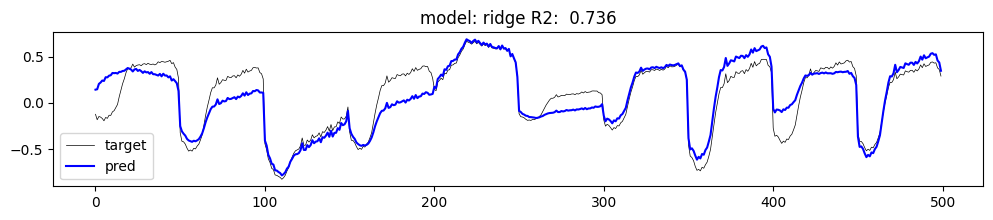

In [175]:
r2, test_pred, test_y = eval_model(_train, _test, model, model_type='ridge', plot=True)

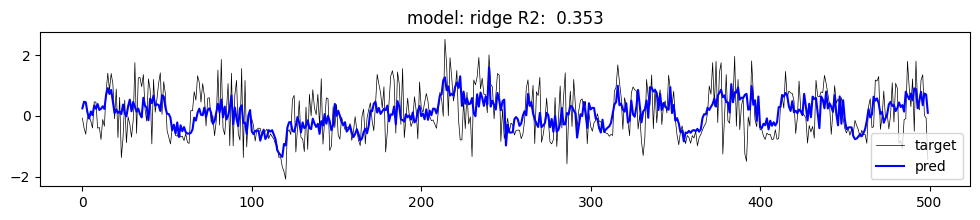

In [176]:
r2, test_pred, test_y = eval_model(dm.train, dm.test, model, model_type='ridge', plot=True)

In [111]:
eid = eids[-1]
target = 'wheel_speed'
r2s = r2_decomp(
    eid, target=target, 
    model=model, model_class='ridge', 
    data_dir=data_dir, n_comp=10
)

spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
Original Data R2: 0.255386318147989
PC 1 R2: 0.2067975685749446
PC 2 R2: 0.4253051144008282
PC 3 R2: 0.45558976809197405
PC 4 R2: 0.5758152904768431
PC 5 R2: 0.09392016900323182
PC 6 R2: 0.14269868642207467
PC 7 R2: 0.05770208789546892
PC 8 R2: -0.12360072981796595
PC 9 R2: 0.1988316162482842
PC 10 R2: -0.028633700598118282


In [110]:
eid = eids[-1]
target = 'motion_energy'
r2s = r2_decomp(
    eid, target=target, 
    model=model, model_class='ridge', 
    data_dir=data_dir, n_comp=10
)

spike data shape: (715, 50, 2263)
behavior data shape: (715, 50)
Original Data R2: 0.3531389104942869
PC 1 R2: 0.7495165910139971
PC 2 R2: 0.7336950844940842
PC 3 R2: 0.5803694667769682
PC 4 R2: 0.5967642718939707
PC 5 R2: 0.45819331837708416
PC 6 R2: 0.1600597162842651
PC 7 R2: 0.2895795936422972
PC 8 R2: 0.029678992719889677
PC 9 R2: 0.06560330819933163
PC 10 R2: 0.05200686198321065


In [ ]:
model_class = 'ridge'
n_eids = len(eids)
targets = ['wheel_speed', 'motion_energy', 'pupil_diameter']
fig, axes = plt.subplots(n_eids, len(targets)*3, figsize=(4*len(targets)*3, 2*n_eids))

for i, eid in enumerate(eids):
    for j, target in enumerate(targets):        
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, r2, test_pred, test_y = behavior_decomp(
            eid, target=target, 
            model=model, model_class=model_class, data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].plot(test_y[:3].flatten(), c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j].plot(test_pred[:3].flatten(), c='k', linewidth=1.5, alpha=1., label='pred')
        axes[i,j].set_title(f'{target} R2: {r2:.3f}')
            
        axes[i,j+len(targets)].plot(signal_decomp, c='gray', linewidth=3, alpha=.5, label='target')
        axes[i,j+len(targets)].plot(recon_decomp, c='k', linewidth=1., alpha=1., label='pred')
        axes[i,j+len(targets)].plot(error_decomp, c='orange', linewidth=1.5, alpha=1., linestyle='--', label='error (pred - target)')
        axes[i,j+len(targets)].set_title(f'{target} ({eid[:8]})')
        axes[i,j+len(targets)].set_xlabel('PC')
        axes[i,j+len(targets)].set_ylabel('Var')
        if np.logical_and(i == 0, j == 0):
            axes[i,0].legend(frameon=False)
            axes[i,len(targets)].legend(frameon=False)

        r2s = r2_decomp(
            eid, target=target, 
            model=model, model_class='ridge', 
            data_dir=data_dir, n_comp=10
        )
        axes[i,j+2*len(targets)].bar(np.arange(len(r2s)), r2s)
        axes[i,j+2*len(targets)].set_title(f'{target} ({eid[:8]})')
        axes[i,j+2*len(targets)].set_xlabel('PC (1st bar is original behavior)')
        axes[i,j+2*len(targets)].set_ylabel('R2')
            
plt.tight_layout()
plt.savefig('../results/plots/pca_behavior_decomp.png', dpi=200)

#### Plotting

In [36]:
res_dir = Path('/home/yizi/shared_decoding/results/pc_results')

eids = [fname for fname in os.listdir(res_dir) if fname not in ['.DS_Store', '.ipynb_checkpoints']]
print(eids)

targets = ['wheel_speed', 'motion_energy', 'pupil_diameter']
models = ['ridge', 'mlp', 'lstm', 'reduced-rank',]

['111c1762-7908-47e0-9f40-2f2ee55b6505', '09b2c4d1-058d-4c84-9fd4-97530f85baf6', '413a6825-2144-4a50-b3fc-cf38ddd6fd1a', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '56b57c38-2699-4091-90a8-aba35103155e', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9', '0a018f12-ee06-4b11-97aa-bbbff5448e9f', '3537d970-f515-4786-853f-23de525e110f', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438']


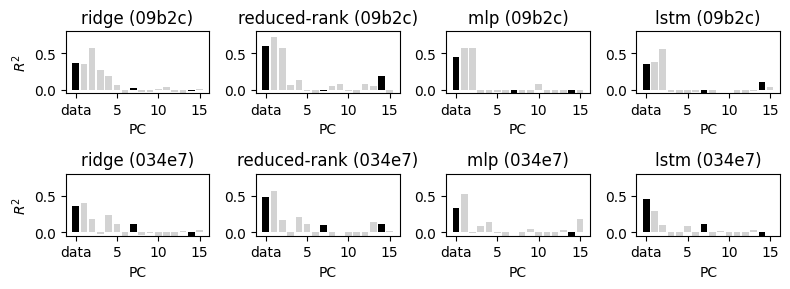

In [5]:
colors = ['k'] + list(np.repeat('lightgray', 6))

target = targets[2]

fig, axes = plt.subplots(len(eids), len(models), figsize=(8,3))
for i, eid in enumerate(eids):  
    min_r2, max_r2 = 0., .75
    for j, model in enumerate(models):
        r2s = []
        for comp_idx in range(-1, 15):
            path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
            try:
                r2 = np.load(path, allow_pickle=True).item()['r2']
            except:
                r2 = np.nan
            # min_r2 = r2 if r2 < min_r2 else min_r2
            # max_r2 = r2 if r2 > max_r2 else max_r2
            r2s.append(r2)
        axes[i,j].bar(np.arange(len(r2s)), r2s, color=colors)
        axes[i,j].set_title(model + f' ({eid[:5]})')
        axes[i,j].set_ylim(min_r2-.05, max_r2+.05)
        axes[i,j].set_xlabel('PC')
        axes[i,j].set_xticks([0, 5, 10, 15], ['data', 5, 10, 15])
        if j == 0:
            axes[i,j].set_ylabel(r'$R^2$')
plt.tight_layout()
# plt.savefig(f'../results/plots/{target}_r2_decomp.png', dpi=100)

In [ ]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
model = GridSearchCV(Ridge(), {"alpha": alphas})

fig, axes = plt.subplots(len(eids), len(targets), figsize=(8,5))
for i, eid in enumerate(eids):  
    for j, target in enumerate(targets):
        signal_decomp, recon_decomp, error_decomp, pca_var_explained, _, _, _ = behavior_decomp(
            eid, target=target, 
            model=model, model_class='ridge', data_dir=data_dir, decomp_type='PCA'
        )
        axes[i,j].bar(np.arange(len(pca_var_explained)), pca_var_explained)
        axes[i,j].set_title(f'{target} ({eid[:5]})')
        axes[i,j].set_xlabel('PC')
        if j == 0:
            axes[i,j].set_ylabel('Exp Var')
plt.tight_layout()
# plt.savefig(f'../results/plots/exp_var.png', dpi=100)

In [ ]:
model = 'reduced-rank'
target = 'motion_energy'

for comp_idx in range(-1, 15):
    path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
    pred = np.load(path, allow_pickle=True).item()['pred']
    gt = np.load(path, allow_pickle=True).item()['target']
    plt.plot(gt[:5].flatten(), color='k', linewidth=1)
    plt.plot(pred[:5].flatten(), color='lightgray', linewidth=2)
    plt.legend()
    plt.show()

In [64]:
df_dict = {}
for target in targets:
    df_dict[target] = {}
    dataframes = []
    for eid in eids:
        if eid in [
            '413a6825-2144-4a50-b3fc-cf38ddd6fd1a', 
            '111c1762-7908-47e0-9f40-2f2ee55b6505', 
            '3537d970-f515-4786-853f-23de525e110f',
            '0a018f12-ee06-4b11-97aa-bbbff5448e9f',
            'd23a44ef-1402-4ed7-97f5-47e9a7a504d9'
        ]:
            continue
        for model in models:
            r2s = []
            for comp_idx in range(-1, 11):
                path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
                try:
                    r2 = np.load(path, allow_pickle=True).item()['r2']
                except:
                    r2 = np.nan
                if model in ['lstm', 'mlp'] and r2 < -.4:
                    continue
                    
                if model == 'reduced-rank' and comp_idx == 0:
                    if r2 < 0:
                        continue
                r2s.append(r2)
            df = pd.DataFrame({
                'pc': list(range(len(r2s))), 
                'r2': r2s,
                'model': list(np.repeat(model, len(r2s)))
            })
            dataframes.append(df) 
    combined_df = pd.concat(dataframes)
    df_dict[target] = combined_df

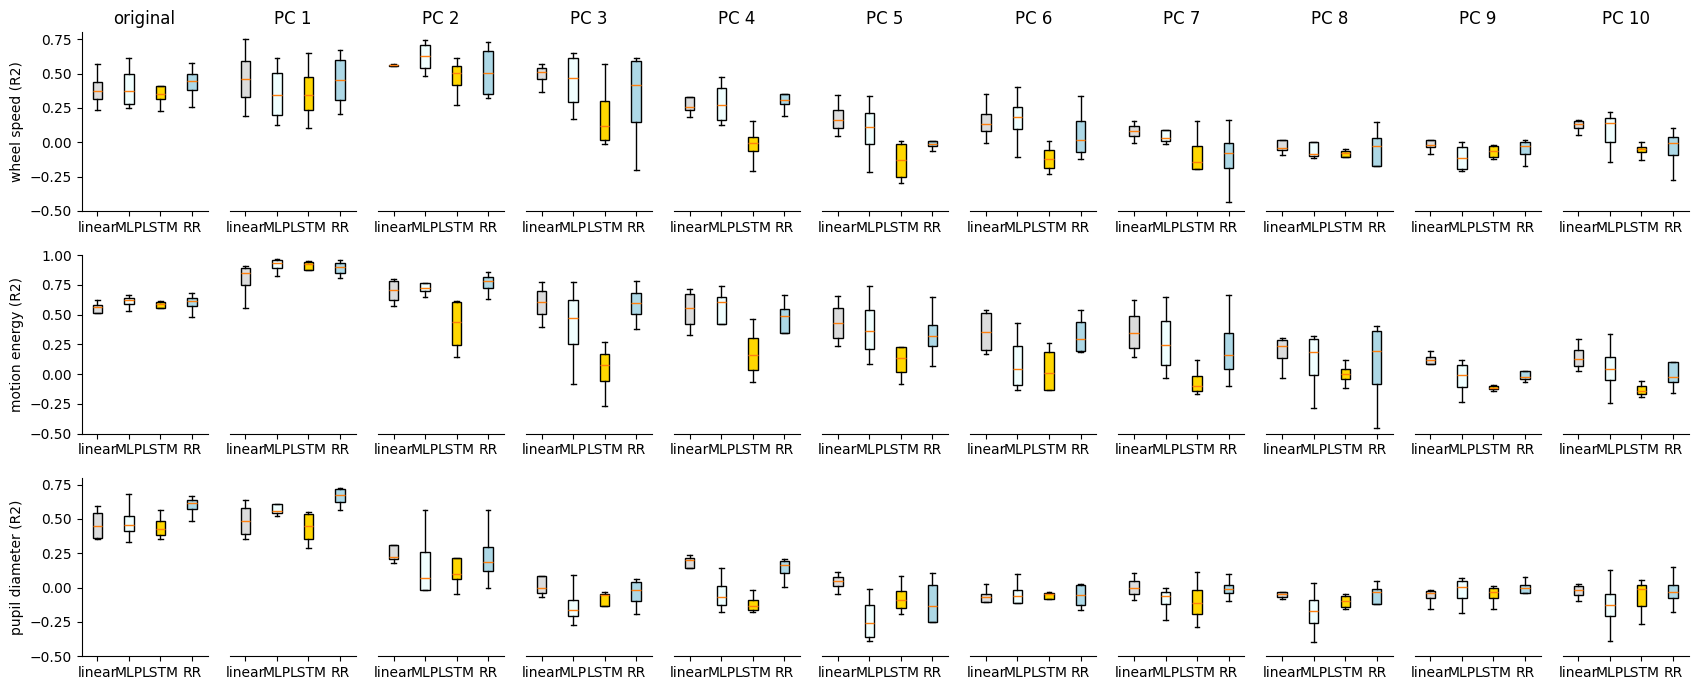

In [97]:
colors = ['royalblue', 'skyblue', 'gold', 'coral']

n_pcs = 11
fig, axes = plt.subplots(len(targets), n_pcs, figsize=(8.5*2,7))

for i, target in enumerate(targets):
    for j in range(n_pcs):
        df = df_dict[target]
        df = df[df.pc == j]
        grouped_df = [df[df.model == model]['r2'] for model in models]
        bplot = axes[i,j].boxplot(
            grouped_df, showfliers=False, widths=0.3, patch_artist = True, #colors='gainsboro'
        )
        colors = ['gainsboro', 'azure', 'gold', 'lightblue']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        axes[i,j].legend('', frameon=False)
        axes[i,j].set_xticks([1,2,3,4], ['linear','MLP','LSTM','RR'])
        if j != 0:
            axes[i,j].spines[['left', 'right', 'top']].set_visible(False)
            axes[i,j].set_yticks([], [])
        else:
            axes[i,j].spines[['right', 'top']].set_visible(False)
        if target == 'wheel_speed':  
            axes[i,j].set_ylim(-.5, .8)
        elif target == 'motion_energy':  
            axes[i,j].set_ylim(-.5, 1.)
        elif target == 'pupil_diameter':  
            axes[i,j].set_ylim(-.5, .8)
        if (i == 0) & (j == 0):
            axes[i,j].set_title(f'original')
        elif (i == 0) & (j != 0):
            axes[i,j].set_title(f'PC {j}')
        axes[i,0].set_ylabel(f'{" ".join(target.split("_"))} (R2)')
plt.tight_layout()
plt.savefig(f'../results/plots/perf_by_pc.png', dpi=500)

In [10]:
base_dir = Path('/mnt/3TB/yizi/shared_decoding')
data_dir = base_dir/'data'

In [13]:
eid = eids[0]
model = 'reduced-rank'
target = 'motion_energy'

DEVICE = torch.device('cpu')

config = {
    'data_dir': data_dir,
    'temporal_rank': 5,
    'weight_decay': 1e-1,
    'learning_rate': 1e-2,
    'batch_size': 8,
    'eid': eid,
    'comp_idxs': None,
    'imposter_id': None,
    'target': target,
    'lstm_hidden_size': 32,
    'lstm_n_layers': 3,
    'mlp_hidden_size': (256, 128, 64),
    'drop_out': 0.,
    'lr_factor': 0.1,
    'lr_patience': 5,
    'device': DEVICE,
    'n_workers': os.cpu_count()
}

dm = SingleSessionDataModule(config)
dm.setup()

train_y = []
for (x, y) in dm.train:
    train_y.append(y.cpu())
train_y = torch.stack(train_y)

val_y = []
for (x, y) in dm.val:
    val_y.append(y.cpu())
val_y = np.stack(val_y)

test_y = []
for (x, y) in dm.test:
    test_y.append(y.cpu())
test_y = np.stack(test_y)

all_y = np.vstack([train_y, val_y, test_y])

pca = PCA(n_components=config['n_t_steps'])
pca.fit(all_y.reshape((-1, config['n_t_steps'])))
pca_basis = pca.components_

spike data shape: (598, 50, 1021)
behavior data shape: (598, 50)
(598, 50)
Use the original behaviors.


In [30]:
from sklearn.metrics import r2_score

In [18]:
path = res_dir/eid/target/model/f'comp_-1.npy'
pred = np.load(path, allow_pickle=True).item()['pred']
gt = np.load(path, allow_pickle=True).item()['target']

In [37]:
r2_decomp = []
for comp_idx in range(15):
    gt_decomp = (pca_basis[comp_idx] @ gt.T).T
    pred_decomp = (pca_basis[comp_idx] @ pred.T).T
    r2_decomp.append(r2_score(gt_decomp, pred_decomp))

In [40]:
r2_per_pc = []
for comp_idx in range(15):
    path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
    r2 = np.load(path, allow_pickle=True).item()['r2']
    r2_per_pc.append(r2)

In [ ]:
df_dict = {}
for target in targets:
    
    df_dict[target] = {}
    dataframes = []
    
    for eid in eids:
        
        DEVICE = torch.device('cpu')
        config = {
            'data_dir': data_dir,
            'temporal_rank': 5,
            'weight_decay': 1e-1,
            'learning_rate': 1e-2,
            'batch_size': 8,
            'eid': eid,
            'comp_idxs': None,
            'imposter_id': None,
            'target': target,
            'lstm_hidden_size': 32,
            'lstm_n_layers': 3,
            'mlp_hidden_size': (256, 128, 64),
            'drop_out': 0.,
            'lr_factor': 0.1,
            'lr_patience': 5,
            'device': DEVICE,
            'n_workers': os.cpu_count()
        }
        
        dm = SingleSessionDataModule(config)
        dm.setup()
        
        train_y = []
        for (x, y) in dm.train:
            train_y.append(y.cpu())
        train_y = torch.stack(train_y)
        
        val_y = []
        for (x, y) in dm.val:
            val_y.append(y.cpu())
        val_y = np.stack(val_y)
        
        test_y = []
        for (x, y) in dm.test:
            test_y.append(y.cpu())
        test_y = np.stack(test_y)
        
        all_y = np.vstack([train_y, val_y, test_y])
        
        pca = PCA(n_components=config['n_t_steps'])
        pca.fit(all_y.reshape((-1, config['n_t_steps'])))
        pca_basis = pca.components_
        
        for model in models:
            r2s = []
            for comp_idx in range(15):
                path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
                r2 = np.load(path, allow_pickle=True).item()['r2']
                r2s.append(r2)
        
            path = res_dir/eid/target/model/f'comp_-1.npy'
            pred = np.load(path, allow_pickle=True).item()['pred']
            gt = np.load(path, allow_pickle=True).item()['target']
            for comp_idx in range(15):
                gt_decomp = (pca_basis[comp_idx] @ gt.T).T
                pred_decomp = (pca_basis[comp_idx] @ pred.T).T
                r2 = r2_score(gt_decomp, pred_decomp)
                r2s.append(r2)
            
            df = pd.DataFrame({
                'pc': np.repeat(np.arange(15)[:,None], 2, 1).T.flatten(), 
                'r2': r2s,
                'model': np.repeat(model, len(r2s)),
                'type': np.c_[np.repeat('decomp', 15), np.repeat('per_pc', 15)].T.flatten() 
            })
            dataframes.append(df) 
    combined_df = pd.concat(dataframes)
    df_dict[target] = combined_df

In [116]:
targets

['wheel_speed', 'motion_energy', 'pupil_diameter']

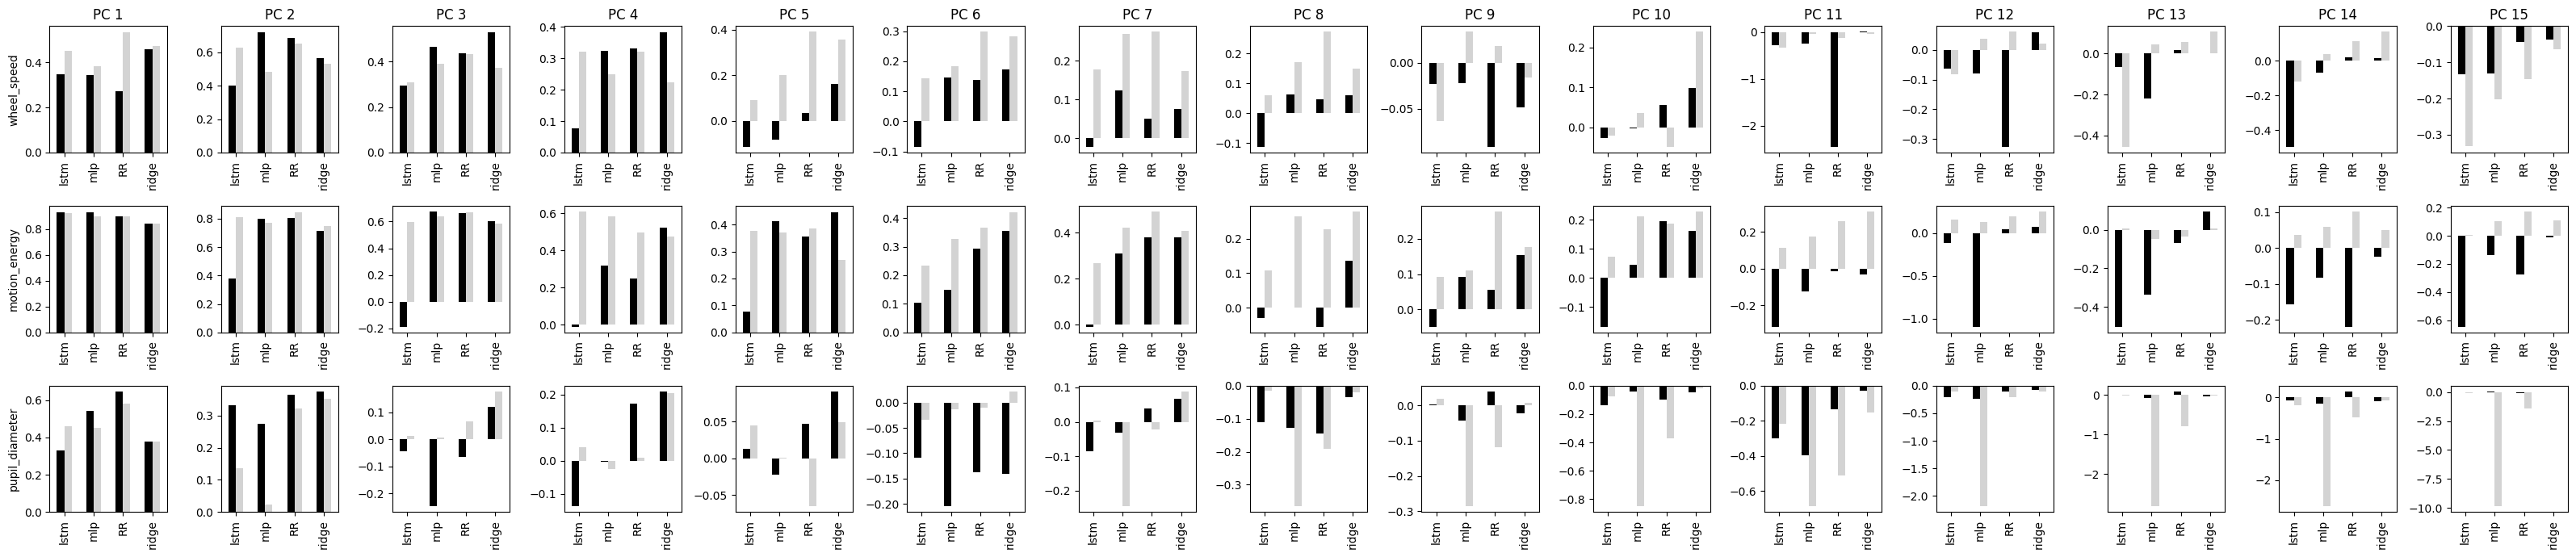

In [125]:
colors = ['k', 'lightgray']

n_pcs = 15
fig, axes = plt.subplots(len(targets), n_pcs, figsize=(32,7))

for i, target in enumerate(targets):
    for j in range(n_pcs):
        df = df_dict[target]
        df = df[df.pc == j]
        grouped_df = df.groupby(['model', 'type'])['r2'].mean().unstack()
        # grouped_df.reindex(index=['ridge', 'reduced-rank', 'mlp', 'lstm'])
        grouped_df.index = ['lstm', 'mlp', 'RR', 'ridge']
        grouped_df.plot(kind='bar', ax=axes[i,j], color=colors)
        axes[0,j].set_title(f'PC {j+1}')
        axes[0,0].set_ylabel('wheel_speed')
        axes[1,0].set_ylabel('motion_energy')
        axes[2,0].set_ylabel('pupil_diameter')
        axes[i,j].legend('', frameon=False)
plt.tight_layout()
plt.savefig(f'../results/plots/r2_decomp_vs_perPC.png', dpi=100)

In [25]:
df_dict = {}
for target in targets:
    df_dict[target] = {}
    dataframes = []
    for eid in eids[:2]:
        for model in models:
            r2s = []
            for comp_idx in [-1, 'smooth']:
                path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
                try:
                    r2 = np.load(path, allow_pickle=True).item()['r2']
                except:
                    r2 = np.nan
                r2s.append(r2)
            df = pd.DataFrame({
                'pc': list(range(len(r2s))), 
                'r2': r2s,
                'model': list(np.repeat(model, len(r2s)))
            })
            dataframes.append(df) 
    combined_df = pd.concat(dataframes)
    df_dict[target] = combined_df

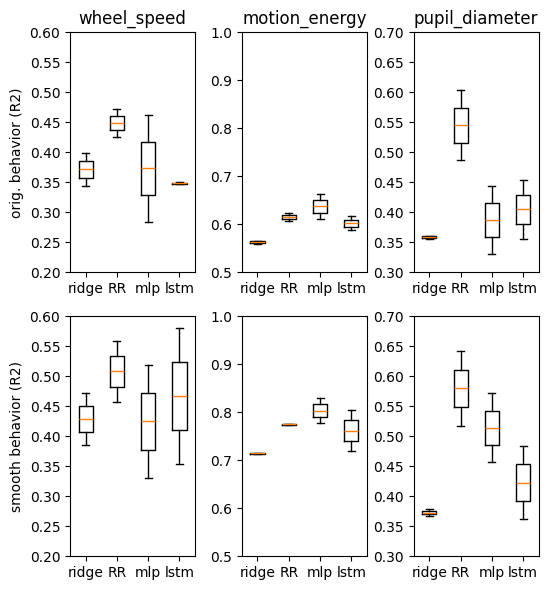

In [34]:
n_pcs = 2
fig, axes = plt.subplots(n_pcs, len(targets), figsize=(5.5,6))

for i in range(n_pcs):
    for j, target in enumerate(targets):
        df = df_dict[target]
        df = df[df.pc == i]
        grouped_df = [df[df.model == model]['r2'] for model in models]
        axes[i,j].boxplot(grouped_df, showfliers=True)
        axes[i,j].legend('', frameon=False)
        axes[i,j].set_xticks([1,2,3,4], ['ridge','RR','mlp','lstm'])
        if target == 'wheel_speed':  
            axes[i,j].set_ylim(0.2, .6)
        elif target == 'motion_energy':  
            axes[i,j].set_ylim(0.5, 1.)
        elif target == 'pupil_diameter':  
            axes[i,j].set_ylim(0.3, 0.7)
        axes[0,j].set_title(f'{target}')
        axes[0,0].set_ylabel(f'orig. behavior (R2)')
        axes[1,0].set_ylabel(f'smooth behavior (R2)')
plt.tight_layout()
# plt.savefig(f'../results/plots/perf_orig_vs_smooth.png', dpi=100)

In [19]:
res_dir = Path('/home/yizi/shared_decoding/results/pc_results')

eids = [fname for fname in os.listdir(res_dir) if fname not in ['.DS_Store', '.ipynb_checkpoints']]
print(eids)

targets = ['wheel_speed', 'motion_energy', 'pupil_diameter']
models = ['ridge', 'mlp', 'lstm', 'reduced-rank', ]

['111c1762-7908-47e0-9f40-2f2ee55b6505', '09b2c4d1-058d-4c84-9fd4-97530f85baf6', '413a6825-2144-4a50-b3fc-cf38ddd6fd1a', '034e726f-b35f-41e0-8d6c-a22cc32391fb', '56b57c38-2699-4091-90a8-aba35103155e', 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9', '0a018f12-ee06-4b11-97aa-bbbff5448e9f', '3537d970-f515-4786-853f-23de525e110f', 'f312aaec-3b6f-44b3-86b4-3a0c119c0438']


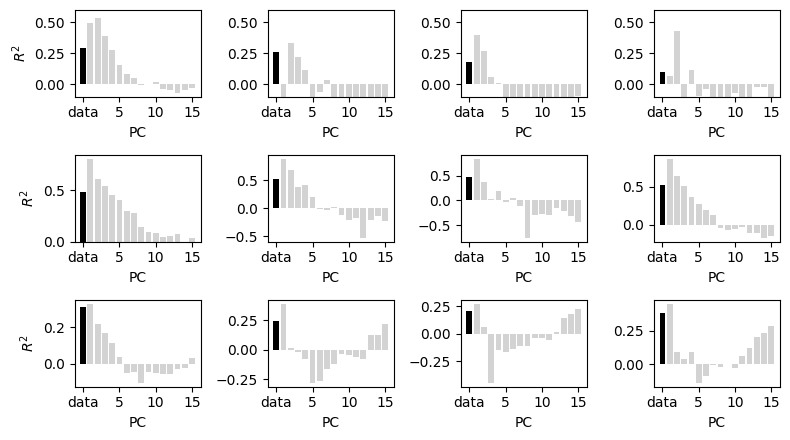

In [23]:
colors = ['k'] + list(np.repeat('lightgray', 15))

fig, axes = plt.subplots(len(targets), len(models), figsize=(8,4.5)) 
for i, target in enumerate(targets):
    for j, model in enumerate(models):
        avg_r2 = []
        for _, eid in enumerate(eids): 
            r2s = []
            for comp_idx in range(-1, 15):
                path = res_dir/eid/target/model/f'comp_{comp_idx}.npy'
                try:
                    r2 = np.load(path, allow_pickle=True).item()['r2']
                except:
                    r2 = np.nan
                # if r2 >= 0:
                r2s.append(r2)
            avg_r2.append(r2s)
        r2s = np.nanmean(avg_r2, 0)
        axes[i,j].bar(np.arange(len(r2s)), r2s, color=colors)
        # axes[i,j].set_title(model + f' ({eid[:5]})')
        if target == 'wheel_speed':
            axes[i,j].set_ylim(-0.1, 0.6)
        axes[i,j].set_xlabel('PC')
        axes[i,j].set_xticks([0, 5, 10, 15], ['data', 5, 10, 15])
        if j == 0:
            axes[i,j].set_ylabel(r'$R^2$')
plt.tight_layout()
# plt.savefig(f'../results/plots/{target}_r2_decomp.png', dpi=100)